In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import geocluster as gc
from graph_library import generate_SBM, assign_graph_metadata
import networkx as nx
import scipy as sc
import pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FFMpegWriter
from geocluster import plotting
import matplotlib.colors as col

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate graph

In [56]:
graph, pos = generate_SBM(params = {'n':[30,30,30,30],
                                    'p':[[0.8, 0.1, 0.02, 0.02],
                                        [0.1, 0.8, 0.02, 0.02],
                                        [0.02, 0.02, 0.8, 0.1],
                                        [0.02, 0.02, 0.1, 0.8]],
                                    'seed': 1})        
graph = nx.convert_node_labels_to_integers(graph)
graph = assign_graph_metadata(graph, pos=pos)

# Plot graph and geodesics between two communities

<IPython.core.display.Javascript object>


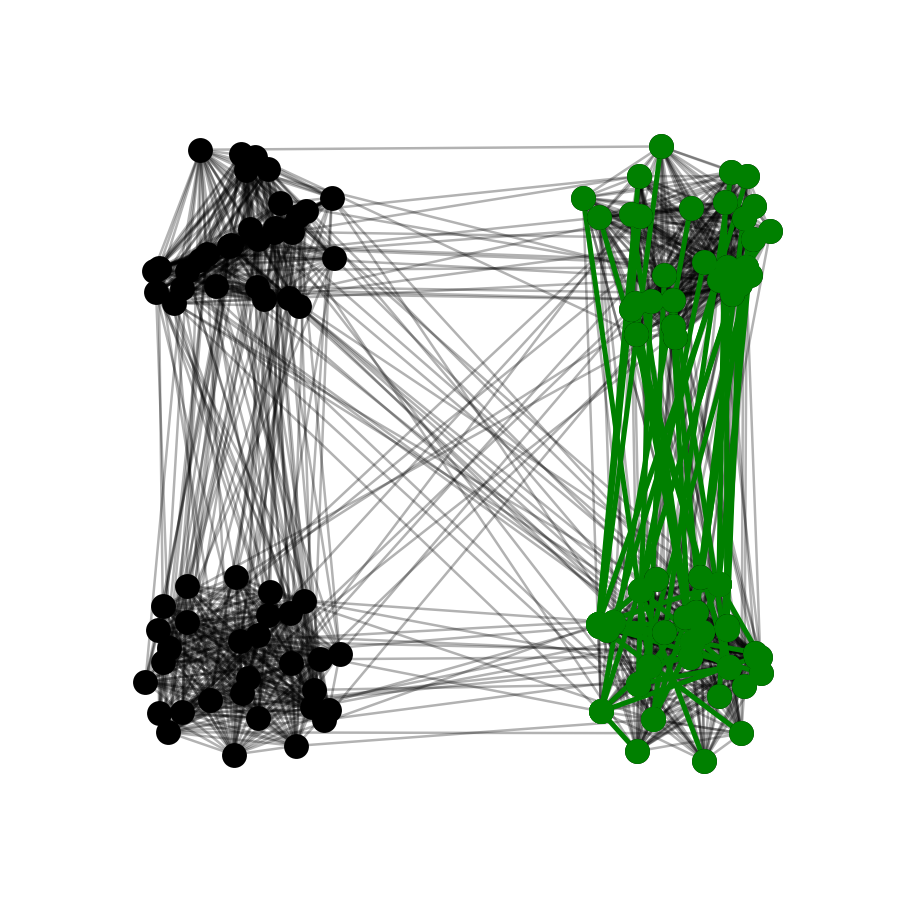

In [24]:
plt.figure(figsize=(5,5))
nx.draw_networkx_nodes(graph,pos,node_size=80,node_color='k')
nx.draw_networkx_edges(graph,pos,edge_color='k',width=1,alpha=0.3)    
for i in range(30):
    path = nx.shortest_path(graph,source=i,target=30+i)
    path_edges = list(zip(path,path[1:]))
    nx.draw_networkx_nodes(graph,pos,nodelist=path,node_size=80,node_color='g')
    nx.draw_networkx_edges(graph,pos,edgelist=path_edges,edge_color='g',width=2)  
 
plt.box(on=None)
#plt.savefig('geodesics.svg')    

# Compute curvatures

In [57]:
times = np.logspace(-2, 2, 50)
params = {'n_workers': 1, 'GPU': False, 'lambda': 0, 
          'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}
kappas = gc.compute_curvatures(graph, times, params, disable=True)

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


<IPython.core.display.Javascript object>


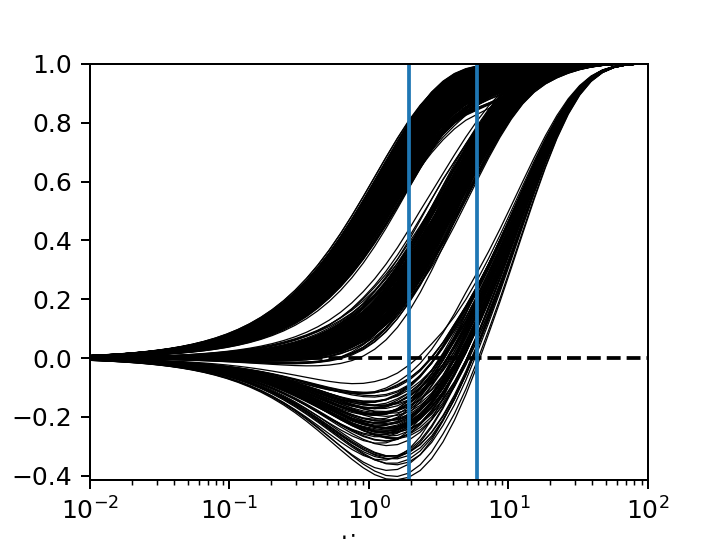

In [58]:
plotting.plot_edge_curvatures(times, kappas, figsize=(4,3))
plt.xlabel('time')
plt.ylabel(r'$\kappa$')

plt.axvline(times[28])
plt.axvline(times[34])
#plt.savefig('curvature_trajectories.svg')

<IPython.core.display.Javascript object>


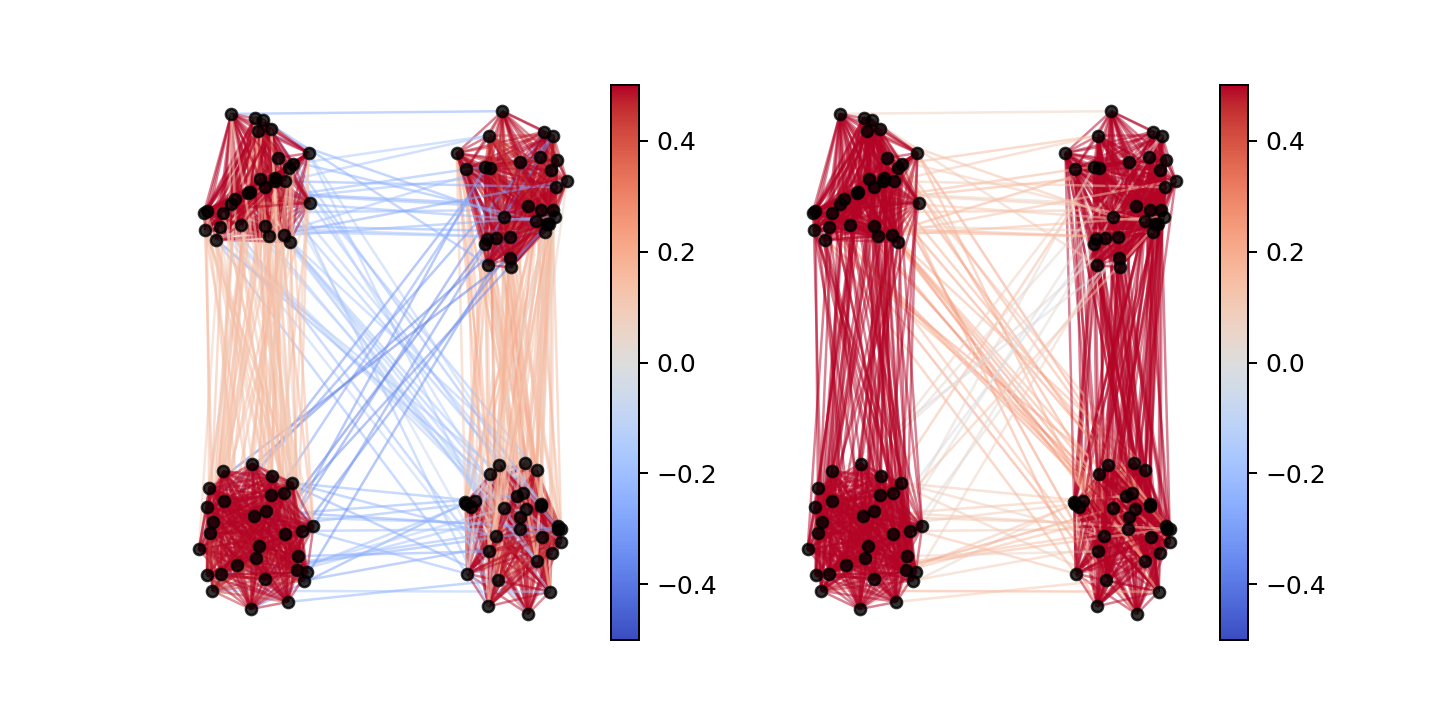

In [59]:
plt.figure(figsize=(8,4))
plt.subplot(121)

kappa = kappas[25]
plotting.plot_graph(
    graph,
    edge_color=kappa,
    node_size=20,
    edge_width=1,
    node_colors='k',
    colormap="standard",
    vmin=-.5,
    vmax=0.5,
)

plt.subplot(122)

kappa = kappas[34]
plotting.plot_graph(
    graph,
    edge_color=kappa,
    node_size=20,
    edge_width=1,
    node_colors='k',
    colormap="standard",
    vmin=-.5,
    vmax=0.5,
)

#plt.savefig('curvature_on_graph.svg')

# Compute geodesic distance matrix

<IPython.core.display.Javascript object>


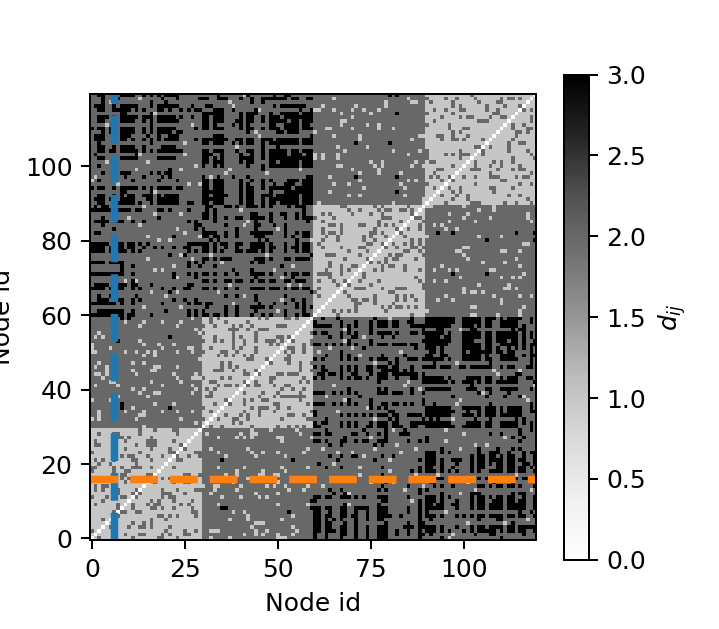

(-0.5, 119.5, -0.5, 119.5)

In [29]:
dist = gc.curvature.compute_distance_geodesic(graph)

plt.figure(figsize=(4,3.5))
plt.imshow(dist,aspect='auto', origin='auto',cmap='Greys')

plt.axvline(6, c='C0',lw=3,ls='--')
plt.axhline(16, c='C1',lw=3,ls='--')

plt.xlabel('Node id')
plt.ylabel('Node id')
plt.colorbar(label=r'$d_{ij}$')
plt.axis('square')

#plt.savefig('distance.svg', bbox_inches='tight')

# Functions to compute measures and make plots

In [42]:
# compute all neighbourhood densities
def mx_comp(graph, T, i):
    
    degrees = np.array([graph.degree[i] for i in graph.nodes])
    L = nx.laplacian_matrix(graph).dot(sc.sparse.diags(1.0 / degrees))
    
    N = len(graph.nodes)

    def delta(i, n):
        p0 = np.zeros(n)
        p0[i] = 1.
        return p0

    mx_all = [] 
    mx_tmp = delta(i, N) #set initial condition
    T = [0,] + list(T) #add time 0
    
    for i in range(len((T))-1): 
        #compute exponential by increments (faster than from 0)
        mx_tmp = sc.sparse.linalg.expm_multiply(-(T[i+1]-T[i])*L, mx_tmp)
        mx_all.append(sc.sparse.lil_matrix(mx_tmp))

    return mx_all


# compute curvature for an edge ij
def zeta_comp(mx_all, dist, it, e):
    import ot
    
    i, j = e[0], e[1]
    nt = len(mx_all[0][0])
    K = np.zeros(nt)

    Nx = np.array(mx_all[i][1][it]).flatten()
    Ny = np.array(mx_all[j][1][it]).flatten()
    mx = mx_all[i][0][it].toarray().flatten()
    my = mx_all[j][0][it].toarray().flatten()

    dNxNy = dist[Nx,:][:,Ny].copy(order='C')
    zeta = ot.emd(mx, my, dNxNy) 
            
    return zeta

# plot the curvature on the graph for a given time t
def plot_measure_graph(t, mx1, mx2, kappas, graph, pos, node_size = 100, edge_width = 1, ax=None):

    edge_vmin = -np.max(abs(kappas[:,t]))
    edge_vmax = np.max(abs(kappas[:,t]))
              
    vmin = 0# -np.max(abs(mx))
    vmax = 1#np.max(abs(mx))
    mx1 /= np.max(mx1)
    mx2 /= np.max(mx2)

    node_size1, node_size2 = mx1*node_size, mx2*node_size 

    from matplotlib.markers import MarkerStyle
    ms1 = MarkerStyle('o', fillstyle = 'left')
    ms2 = MarkerStyle('o', fillstyle = 'right')
    node_color1 = 'C0'
    node_color2 = 'C1'

    nodes = nx.draw_networkx_nodes(graph, pos = pos, node_size = node_size1, node_color = node_color1, 
                                   vmin = vmin, vmax = vmax, cmap=plt.get_cmap('viridis'),node_shape=ms1,
                                  ax=ax)
    
    nodes = nx.draw_networkx_nodes(graph, pos = pos, node_size = node_size2, node_color = node_color2, 
                                   vmin = vmin, vmax = vmax, cmap=plt.get_cmap('viridis'),node_shape=ms2,
                                   ax=ax)
    
    #edges = nx.draw_networkx_edges(graph, pos = pos, width = edge_width, alpha=0.3, ax=ax)

    limits = plt.axis('off') #turn axis off
    
    return ax


def plot_transport_plan(zeta, mx1, mx2, ax1, ax2, ax3):       
   
    ax1.imshow((zeta.T), cmap='viridis', norm=col.Normalize(vmin=np.min(zeta), vmax=0.05*np.max(zeta)), aspect='auto', origin='auto')
    ax1.set_xlabel('Node id')
    ax1.set_ylabel('Node id')
  
    ax2.bar(np.arange(len(mx1)), mx1,color='C0',log=False)
    ax2.set_xlim(-0.5,len(mx1)-0.5)
    ax2.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax2.set_ylabel('$p_x$')
    ax2.set_ylim([0,0.03])
    
    ax3.barh(np.arange(len(mx2)),mx2,color='C1',log=False)
    ax3.set_ylim(-0.5,len(mx2)-0.5)
    ax3.set_xlabel('$p_y$')
    ax3.set_xlim([0,0.03])

    ax3.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)

    ax1.axvline(29.5,c='w',ls='--',lw=0.8)
    ax1.axvline(29.5,c='w',ls='--',lw=0.8)
    ax1.axvline(59.5,c='w',ls='--',lw=0.8)
    ax1.axvline(59.5,c='w',ls='--',lw=0.8)
    ax1.axvline(89.5,c='w',ls='--',lw=0.8)
    ax1.axvline(89.5,c='w',ls='--',lw=0.8)
    
    ax1.axhline(29.5,c='w',ls='--',lw=0.8)
    ax1.axhline(29.5,c='w',ls='--',lw=0.8)
    ax1.axhline(59.5,c='w',ls='--',lw=0.8)
    ax1.axhline(59.5,c='w',ls='--',lw=0.8)
    ax1.axhline(89.5,c='w',ls='--',lw=0.8)
    ax1.axhline(89.5,c='w',ls='--',lw=0.8)
    
    return ax1, ax2, ax3

# Make video of diffusion evolution

<IPython.core.display.Javascript object>


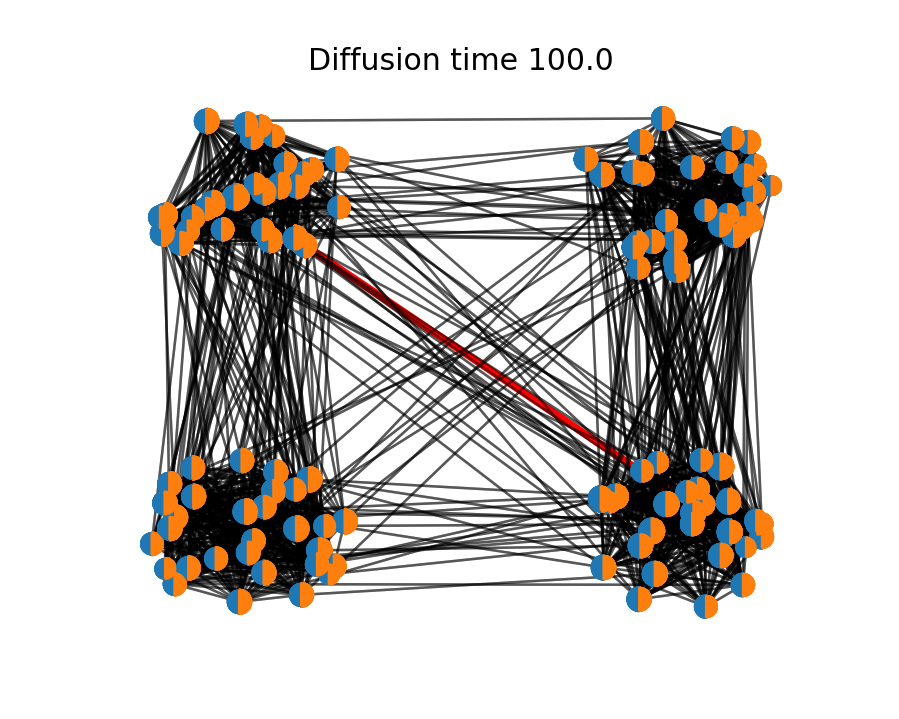

INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '500x400', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie Test', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', 'diffusion_between.mp4']


In [43]:
i = 1
j = 62
    
mx_1 = mx_comp(graph, times, i)
mx_2 = mx_comp(graph, times, j)
    
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

edges = nx.draw_networkx_edges(graph, pos = pos, width = 1, alpha=0.3, ax=ax)
nx.draw_networkx_edges(graph, pos = pos, edgelist=[(i,j),], edge_color='r',width = 3,ax=ax)

metadata = dict(title='Movie Test', artist='Matplotlib',comment='Movie support!')
writer = FFMpegWriter(fps=1, metadata=metadata)
with writer.saving(fig, "diffusion_between.mp4", 100):
    for t in range(len(times)):       
        mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
        ax = plot_measure_graph(t, mx1, mx2, kappas, graph, pos, node_size = 100, edge_width = 1, ax=ax)
        plt.title('Diffusion time ' + str(np.round(times[t],2)))
        writer.grab_frame()

# Plot graph with snapshots of diffusion measures

<IPython.core.display.Javascript object>


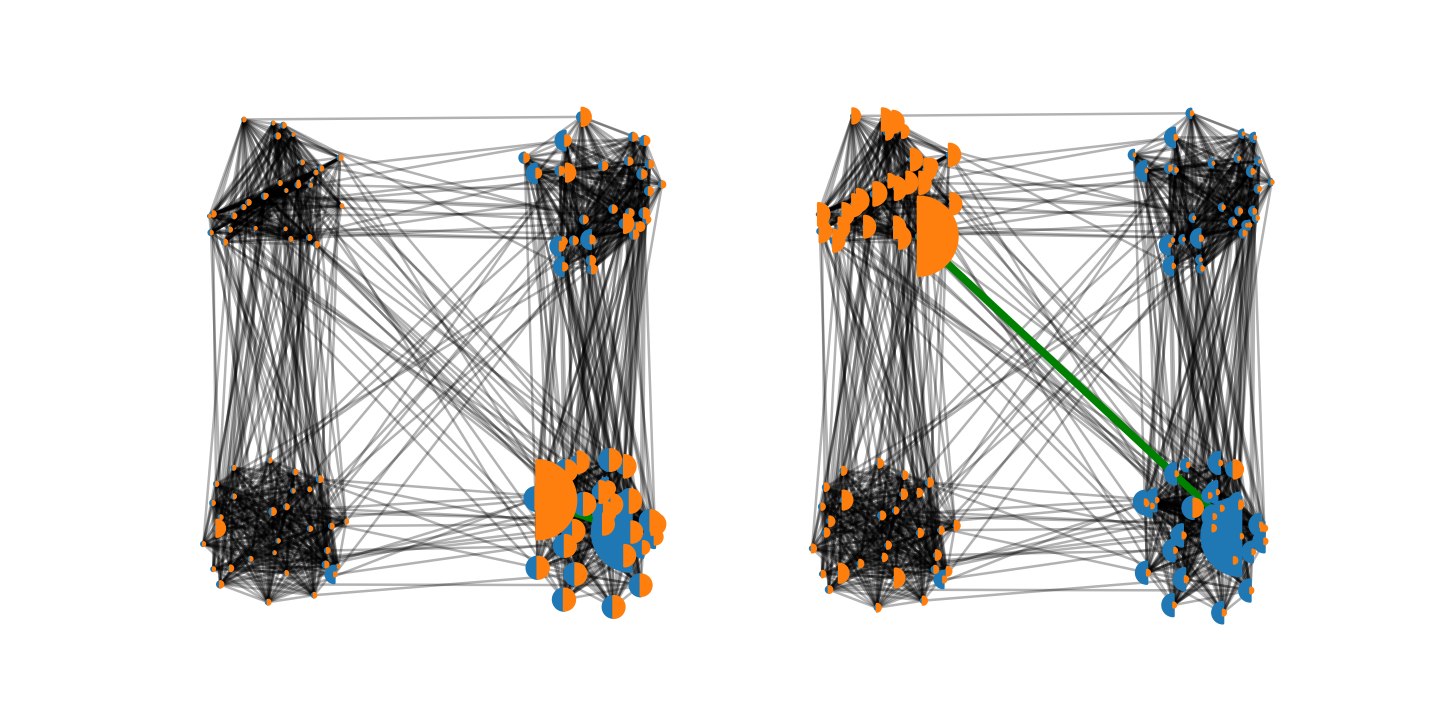

Text(0.5, 1, '0.12244897959183638')

In [49]:
plt.figure(figsize=(8,4))
plt.subplot(121)

t = 26
i = 1
j = 5

mx_1 = mx_comp(graph, times, i)
mx_2 = mx_comp(graph, times, j)
mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()

plot_measure_graph(t, mx1, mx2, kappas, graph, pos, node_size = 1000, edge_width = 1)
nx.draw_networkx_edges(graph, pos = pos, width = 1, alpha=0.3)
nx.draw_networkx_edges(graph, pos = pos, edgelist=[(i,j),], edge_color='g',width = 3)
ax1.set_title(np.log10(times[t]))


plt.subplot(122)

t = 26
i = 1
j = 62

mx_1 = mx_comp(graph, times, i)
mx_2 = mx_comp(graph, times, j)
mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()

plot_measure_graph(t, mx1, mx2, kappas, graph, pos, node_size = 1000, edge_width = 1)
nx.draw_networkx_edges(graph, pos = pos, width = 1, alpha=0.3)
nx.draw_networkx_edges(graph, pos = pos, edgelist=[(i,j),], edge_color='g',width = 3)

ax2.set_title(np.log10(times[t]))

#plt.savefig('mxs.svg', bbox_inches='tight')

# Plot transport maps

<IPython.core.display.Javascript object>


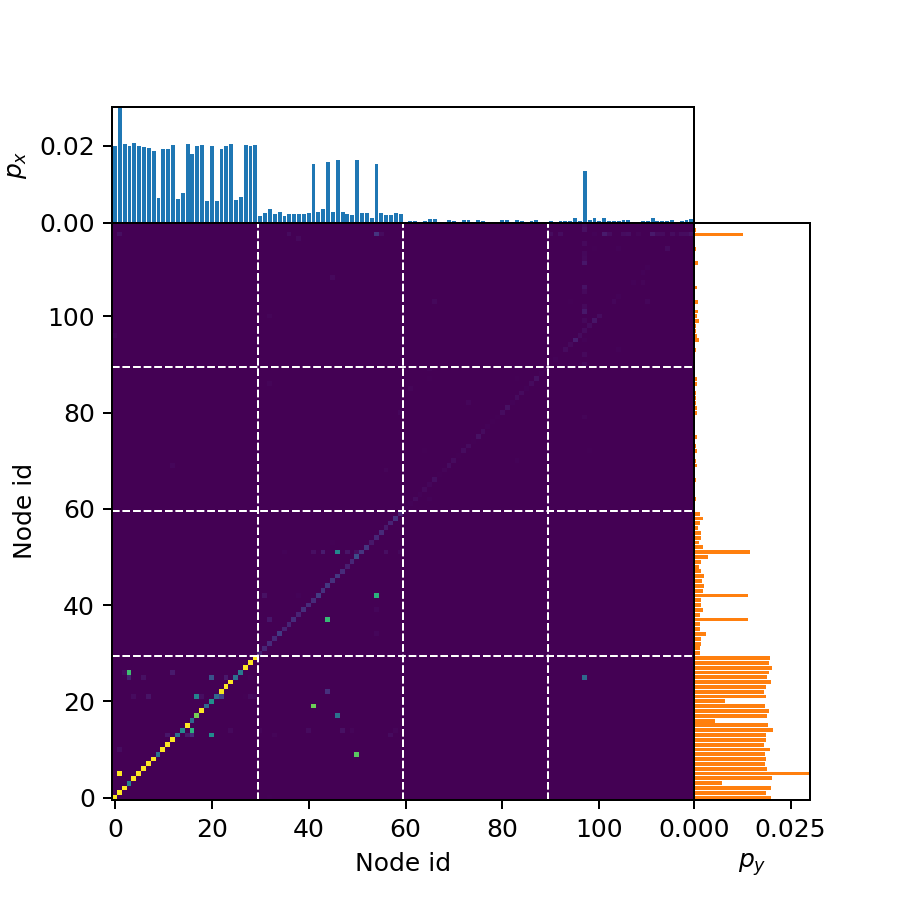

(<matplotlib.axes._subplots.AxesSubplot at 0x7f134da31f10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f134d662b10>)

In [52]:
import ot

t = 25
i = 1
j = 5

mx_all = []
for k in range(nx.number_of_nodes(graph)):
    mx_all.append(mx_comp(graph, times, k))

mx = mx_all[i][t].toarray().flatten()
my = mx_all[j][t].toarray().flatten()

#dNxNy = dist[Nx,:][:,Ny].copy(order='C')
zeta = ot.emd(mx, my, dist) 

fig= plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[1, 1])

plot_transport_plan(zeta, 
                    mx_all[i][t].toarray().flatten(), 
                    mx_all[j][t].toarray().flatten(), 
                    ax1, ax2, ax3)

#plt.savefig('zeta_within.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


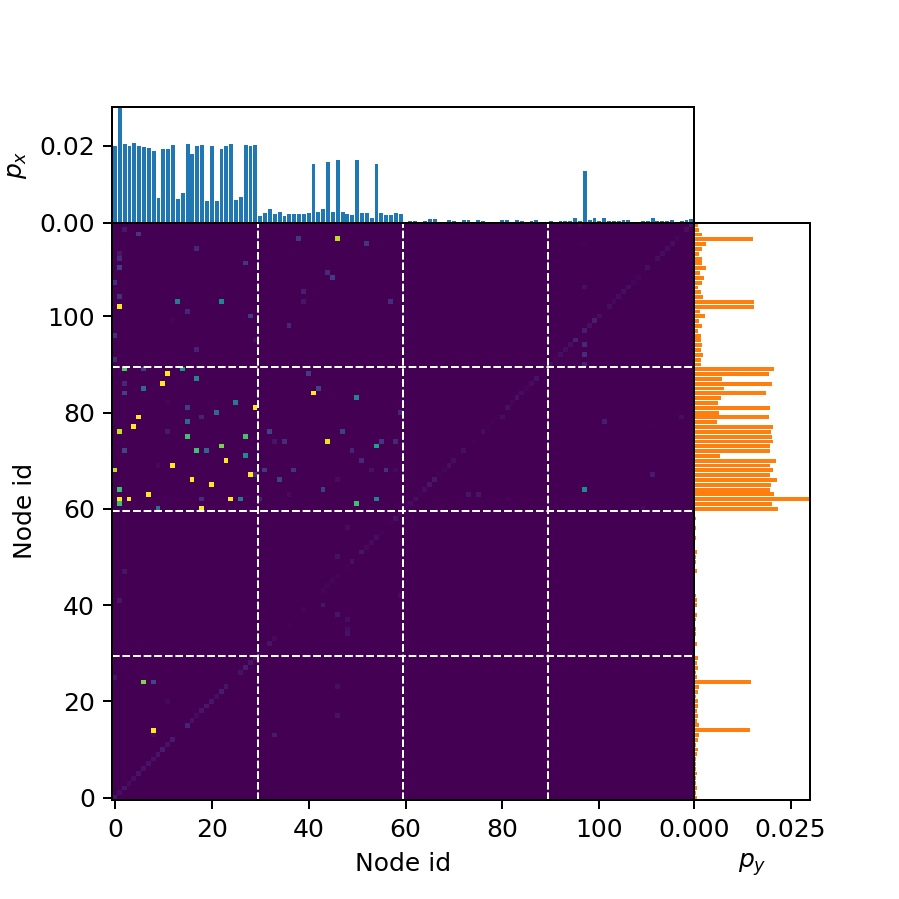

(<matplotlib.axes._subplots.AxesSubplot at 0x7f134d461a50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f134d487190>)

In [54]:
import ot

t = 25
i = 1
j = 62

mx_all = []
for k in range(nx.number_of_nodes(graph)):
    mx_all.append(mx_comp(graph, times, k))

mx = mx_all[i][t].toarray().flatten()
my = mx_all[j][t].toarray().flatten()

zeta = ot.emd(mx, my, dist) 

fig= plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[1, 1])

plot_transport_plan(zeta, 
                    mx_all[i][t].toarray().flatten(), 
                    mx_all[j][t].toarray().flatten(), 
                    ax1, ax2, ax3)

#plt.savefig('zeta_between.svg', bbox_inches='tight')